In [3]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou
import time
import os
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import numpy as np

class FasterRCNNDataset(Dataset):
    def __init__(self, images_dir, labels_dir):
        self.images_dir = Path(images_dir)
        self.labels_dir = Path(labels_dir)
        
        # Get image files
        self.image_files = []
        for ext in ['*.jpg', '*.jpeg', '*.png']:
            self.image_files.extend(list(self.images_dir.glob(ext)))
        
        print(f"Faster R-CNN Dataset: {len(self.image_files)} images in {images_dir}")
        
        # Fixed transform
        self.transform = T.Compose([T.ToTensor()])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Get labels
        label_name = img_path.stem + '.txt'
        label_path = self.labels_dir / label_name
        
        boxes = []
        labels = []
        
        if label_path.exists():
            with open(label_path, 'r') as f:
                for line in f:
                    if line.strip():
                        parts = line.strip().split()
                        if len(parts) >= 5:
                            # YOLO format: class_id x_center y_center width height (normalized)
                            # For Faster R-CNN, we need to add 1 to class_id (background class is 0)
                            class_id = int(parts[0]) + 1  # 1=carretera, 2=rio
                            x_center, y_center, width, height = map(float, parts[1:5])
                            
                            # Convert to absolute coordinates
                            img_width, img_height = image.size
                            x_center *= img_width
                            y_center *= img_height
                            width *= img_width
                            height *= img_height
                            
                            # Convert to [x1, y1, x2, y2]
                            x1 = max(0, x_center - width/2)
                            y1 = max(0, y_center - height/2)
                            x2 = min(img_width, x_center + width/2)
                            y2 = min(img_height, y_center + height/2)
                            
                            # Validate box
                            if x2 > x1 + 1 and y2 > y1 + 1:
                                boxes.append([x1, y1, x2, y2])
                                labels.append(class_id)
        
        # Handle empty annotations
        if len(boxes) == 0:
            boxes = [[0, 0, 10, 10]]  # Small dummy box
            labels = [1]  # Default to carretera (class 1)
        
        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {
            'boxes': boxes,
            'labels': labels,
        }
        
        # Apply transform
        image = self.transform(image)
        
        return image, target

def collate_fn(batch):
    """Collate function for Faster R-CNN dataloaders"""
    return tuple(zip(*batch))

def create_faster_rcnn_dataloaders():
    """Create Faster R-CNN dataloaders"""
    root = Path('data/ImagenesFiltradas')
    
    # Check paths
    train_images = root / 'train' / 'images'
    train_labels = root / 'train' / 'labels'
    val_images = root / 'val' / 'images'
    val_labels = root / 'val' / 'labels'
    
    print("Checking Faster R-CNN paths:")
    for path in [train_images, train_labels, val_images, val_labels]:
        status = "✓" if path.exists() else "✗"
        print(f"  {status} {path}")
    
    # Create datasets
    train_dataset = FasterRCNNDataset(train_images, train_labels)
    val_dataset = FasterRCNNDataset(val_images, val_labels)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=8,  # Smaller batch size for Faster R-CNN (more memory intensive)
        shuffle=True, 
        collate_fn=collate_fn, 
        num_workers=0,
        pin_memory=torch.cuda.is_available()
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=8, 
        shuffle=False, 
        collate_fn=collate_fn, 
        num_workers=0,
        pin_memory=torch.cuda.is_available()
    )
    
    print(f"Faster R-CNN DataLoaders created:")
    print(f"  Train: {len(train_dataset)} images, {len(train_loader)} batches")
    print(f"  Val: {len(val_dataset)} images, {len(val_loader)} batches")
    
    return train_loader, val_loader

def setup_faster_rcnn():
    """Setup Faster R-CNN without freezing - full training"""
    # Load pretrained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Replace the classifier for 3 classes (background + carretera + rio)
    print("Replacing classifier head for 3 classes (including background)...")
    num_classes = 3  # background + carretera + rio
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # Count parameters - all trainable now
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    
    print(f"Faster R-CNN parameters (all trainable):")
    print(f"  Total: {total_params:,}")
    print(f"  Trainable: {trainable_params:,} ({trainable_params/total_params:.1%})")
    
    return model

def calculate_ap(pred_boxes, pred_scores, pred_labels, gt_boxes, gt_labels, iou_threshold=0.5, device='cpu'):
    """Calculate Average Precision for a single class"""
    if len(pred_boxes) == 0:
        return 0.0
    if len(gt_boxes) == 0:
        return 0.0
    
    # Ensure all tensors are on the same device
    pred_boxes = pred_boxes.to(device)
    pred_scores = pred_scores.to(device)
    pred_labels = pred_labels.to(device)
    gt_boxes = gt_boxes.to(device)
    gt_labels = gt_labels.to(device)
    
    # Sort predictions by score (descending)
    sort_idx = torch.argsort(pred_scores, descending=True)
    pred_boxes = pred_boxes[sort_idx]
    pred_scores = pred_scores[sort_idx]
    pred_labels = pred_labels[sort_idx]
    
    # Calculate IoU between all pred and gt boxes
    ious = box_iou(pred_boxes, gt_boxes)
    
    # For each prediction, find best matching ground truth
    tp = torch.zeros(len(pred_boxes), device=device)
    gt_matched = torch.zeros(len(gt_boxes), dtype=torch.bool, device=device)
    
    for i, (pred_box, pred_score, pred_label) in enumerate(zip(pred_boxes, pred_scores, pred_labels)):
        # Find best IoU with ground truth of same class
        best_iou = 0
        best_gt_idx = -1
        
        for j, gt_label in enumerate(gt_labels):
            if pred_label == gt_label and not gt_matched[j]:
                iou = ious[i, j]
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = j
        
        # Check if it's a true positive
        if best_iou >= iou_threshold and best_gt_idx >= 0:
            tp[i] = 1
            gt_matched[best_gt_idx] = True
    
    # Calculate precision and recall
    tp_cumsum = torch.cumsum(tp, dim=0)
    fp_cumsum = torch.cumsum(1 - tp, dim=0)
    
    recall = tp_cumsum / len(gt_boxes)
    precision = tp_cumsum / (tp_cumsum + fp_cumsum)
    
    # Calculate AP using 11-point interpolation
    recall_levels = torch.linspace(0, 1, 11, device=device)
    ap = 0
    for r in recall_levels:
        precisions_above_r = precision[recall >= r]
        if len(precisions_above_r) > 0:
            ap += torch.max(precisions_above_r)
    ap /= 11
    
    return ap.item()

def calculate_map(predictions, targets, num_classes=3, iou_thresholds=None, device='cpu'):
    """Calculate mAP@0.5 and mAP@0.5:0.95"""
    if iou_thresholds is None:
        iou_thresholds = [0.5]  # For mAP@0.5
    
    aps_per_class = []
    
    # Skip background class (class 0), calculate for classes 1 and 2
    for class_id in range(1, num_classes):
        class_aps = []
        
        for iou_thresh in iou_thresholds:
            all_pred_boxes = []
            all_pred_scores = []
            all_pred_labels = []
            all_gt_boxes = []
            all_gt_labels = []
            
            # Collect all predictions and targets for this class
            for pred, target in zip(predictions, targets):
                # Filter predictions for this class
                class_mask = pred['labels'] == class_id
                if class_mask.sum() > 0:
                    all_pred_boxes.append(pred['boxes'][class_mask].cpu())
                    all_pred_scores.append(pred['scores'][class_mask].cpu())
                    all_pred_labels.append(pred['labels'][class_mask].cpu())
                
                # Filter targets for this class
                gt_class_mask = target['labels'] == class_id
                if gt_class_mask.sum() > 0:
                    all_gt_boxes.append(target['boxes'][gt_class_mask].cpu())
                    all_gt_labels.append(target['labels'][gt_class_mask].cpu())
            
            if len(all_pred_boxes) > 0 and len(all_gt_boxes) > 0:
                # Concatenate all boxes/scores/labels
                pred_boxes = torch.cat(all_pred_boxes, dim=0)
                pred_scores = torch.cat(all_pred_scores, dim=0)
                pred_labels = torch.cat(all_pred_labels, dim=0)
                gt_boxes = torch.cat(all_gt_boxes, dim=0)
                gt_labels = torch.cat(all_gt_labels, dim=0)
                
                ap = calculate_ap(pred_boxes, pred_scores, pred_labels, gt_boxes, gt_labels, iou_thresh, device)
                class_aps.append(ap)
            else:
                class_aps.append(0.0)
        
        aps_per_class.append(np.mean(class_aps))
    
    return np.mean(aps_per_class)

def train_faster_rcnn():
    """Train Faster R-CNN with full training (no freezing)"""
    print("=== FASTER R-CNN FULL TRAINING ===")
    
    # Create dataloaders
    train_loader, val_loader = create_faster_rcnn_dataloaders()
    
    # Setup model
    model = setup_faster_rcnn()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    print(f"Training on: {device}")
    print("Class mapping: 0=background, 1=carretera, 2=rio")
    
    # Optimizer for all parameters
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
    
    # Training settings
    epochs = 50
    best_map = 0.0
    patience_counter = 0
    patience = 8
    
    print(f"Training for {epochs} epochs...")
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        num_batches = 0
        
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 30)
        
        for batch_idx, (images, targets) in enumerate(train_loader):
            try:
                # Move to device
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                
                # Forward pass
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                
                # Check for invalid losses
                if torch.isnan(losses) or torch.isinf(losses):
                    print(f"  Skipping batch {batch_idx}: invalid loss")
                    continue
                
                # Backward pass
                optimizer.zero_grad()
                losses.backward()
                
                # Gradient clipping for stability
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                
                epoch_loss += losses.item()
                num_batches += 1
                
                if batch_idx % 10 == 0:
                    print(f'  Batch {batch_idx}/{len(train_loader)}, Loss: {losses.item():.4f}')
                    
            except Exception as e:
                print(f"  Skipping batch {batch_idx}: {e}")
                continue
        
        avg_loss = epoch_loss / num_batches if num_batches > 0 else 0
        
        # Validation and mAP calculation
        if epoch % 5 == 0 or epoch == epochs - 1:  # Calculate mAP every 5 epochs
            map50, map50_95 = evaluate_faster_rcnn_map(model, val_loader, device)
            
            print(f'Epoch {epoch+1} Results:')
            print(f'  Train Loss: {avg_loss:.4f}')
            print(f'  mAP@0.5: {map50:.4f} ({map50*100:.2f}%)')
            print(f'  mAP@0.5:0.95: {map50_95:.4f} ({map50_95*100:.2f}%)')
            
            # Early stopping check
            if map50 > best_map:
                best_map = map50
                patience_counter = 0
                # Save best model
                torch.save(model.state_dict(), 'faster_rcnn_best.pth')
                print(f'  New best mAP@0.5: {best_map:.4f} - Model saved!')
            else:
                patience_counter += 1
                print(f'  No improvement. Patience: {patience_counter}/{patience}')
                
                if patience_counter >= patience:
                    print(f'  Early stopping triggered after {epoch+1} epochs')
                    break
        else:
            print(f'Epoch {epoch+1} completed, Avg Loss: {avg_loss:.4f}')
        
        scheduler.step()
    
    end_time = time.time()
    training_time = end_time - start_time
    print(f"\nFaster R-CNN training completed in {training_time:.2f} seconds")
    print(f"Time per epoch: {training_time/(epoch+1):.1f} seconds")
    print(f"Best mAP@0.5: {best_map:.4f}")
    
    # Save final model
    torch.save(model.state_dict(), 'faster_rcnn_final.pth')
    print(f"Final model saved: faster_rcnn_final.pth")
    
    return model

def evaluate_faster_rcnn_map(model, val_loader, device):
    """Evaluate Faster R-CNN and calculate mAP@0.5 and mAP@0.5:0.95"""
    model.eval()
    
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            predictions = model(images)
            
            # Filter predictions by confidence threshold
            filtered_predictions = []
            for pred in predictions:
                scores = pred['scores']
                mask = scores > 0.05  # Low threshold to capture all potential detections
                
                filtered_pred = {
                    'boxes': pred['boxes'][mask],
                    'scores': pred['scores'][mask],
                    'labels': pred['labels'][mask]
                }
                filtered_predictions.append(filtered_pred)
            
            all_predictions.extend(filtered_predictions)
            all_targets.extend(targets)
    
    # Calculate mAP@0.5 (move computations to CPU for stability)
    map50 = calculate_map(all_predictions, all_targets, num_classes=3, iou_thresholds=[0.5], device='cpu')
    
    # Calculate mAP@0.5:0.95
    iou_thresholds = np.arange(0.5, 1.0, 0.05)  # [0.5, 0.55, 0.6, ..., 0.95]
    map50_95 = calculate_map(all_predictions, all_targets, num_classes=3, iou_thresholds=iou_thresholds, device='cpu')
    
    return map50, map50_95

def evaluate_faster_rcnn():
    """Final evaluation of Faster R-CNN with detailed metrics"""
    print("=== FASTER R-CNN FINAL EVALUATION ===")
    
    # Load model
    model = setup_faster_rcnn()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    if os.path.exists('faster_rcnn_best.pth'):
        model.load_state_dict(torch.load('faster_rcnn_best.pth', map_location=device))
        print("Best Faster R-CNN model loaded successfully")
    elif os.path.exists('faster_rcnn_final.pth'):
        model.load_state_dict(torch.load('faster_rcnn_final.pth', map_location=device))
        print("Final Faster R-CNN model loaded successfully")
    else:
        print("No Faster R-CNN model file found")
        return
    
    model.to(device)
    
    # Get validation loader
    _, val_loader = create_faster_rcnn_dataloaders()
    
    # Calculate mAP metrics
    map50, map50_95 = evaluate_faster_rcnn_map(model, val_loader, device)
    
    class_names = {1: 'carretera', 2: 'rio'}
    
    print(f"\nFinal Faster R-CNN Results:")
    print(f"  mAP@0.5: {map50:.4f} ({map50*100:.2f}%)")
    print(f"  mAP@0.5:0.95: {map50_95:.4f} ({map50_95*100:.2f}%)")
    
    return {
        'map50': map50,
        'map50_95': map50_95
    }

def run_faster_rcnn_pipeline():
    """Complete Faster R-CNN pipeline similar to YOLO"""
    print("FASTER R-CNN TRAINING PIPELINE")
    print("="*50)
    
    start = time.time()
    
    # Train
    model = train_faster_rcnn()
    
    end = time.time()
    print(f"Execution time: {end-start:.2f} seconds")
    
    if model is not None:
        print("\n" + "="*50)
        # Final evaluation
        results = evaluate_faster_rcnn()
        print(f"\nFaster R-CNN pipeline completed!")
        return results
    else:
        print("Faster R-CNN training failed")
        return None

if __name__ == "__main__":
    results = run_faster_rcnn_pipeline()

FASTER R-CNN TRAINING PIPELINE
=== FASTER R-CNN FULL TRAINING ===
Checking Faster R-CNN paths:
  ✓ data\ImagenesFiltradas\train\images
  ✓ data\ImagenesFiltradas\train\labels
  ✓ data\ImagenesFiltradas\val\images
  ✓ data\ImagenesFiltradas\val\labels
Faster R-CNN Dataset: 610 images in data\ImagenesFiltradas\train\images
Faster R-CNN Dataset: 91 images in data\ImagenesFiltradas\val\images
Faster R-CNN DataLoaders created:
  Train: 610 images, 77 batches
  Val: 91 images, 12 batches
Replacing classifier head for 3 classes (including background)...
Faster R-CNN parameters (all trainable):
  Total: 41,304,286
  Trainable: 41,081,886 (99.5%)
Training on: cuda
Class mapping: 0=background, 1=carretera, 2=rio
Training for 50 epochs...

Epoch 1/50
------------------------------
  Batch 0/77, Loss: 1.5525
  Batch 10/77, Loss: 0.5952
  Batch 20/77, Loss: 0.4583
  Batch 30/77, Loss: 1.0857
  Batch 40/77, Loss: 0.3402
  Batch 50/77, Loss: 0.3099
  Batch 60/77, Loss: 0.3247
  Batch 70/77, Loss: 0.3

In [9]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T
from pathlib import Path
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.ops import box_iou
import time

# Model configuration
modelo = 'faster_rcnn_best.pth'  # Change this to your model path

class FasterRCNNDataset(Dataset):
    def __init__(self, images_dir, labels_dir):
        self.images_dir = Path(images_dir)
        self.labels_dir = Path(labels_dir)
        
        # Get image files
        self.image_files = []
        for ext in ['*.jpg', '*.jpeg', '*.png']:
            self.image_files.extend(list(self.images_dir.glob(ext)))
        
        # Fixed transform
        self.transform = T.Compose([T.ToTensor()])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Get labels
        label_name = img_path.stem + '.txt'
        label_path = self.labels_dir / label_name
        
        boxes = []
        labels = []
        
        if label_path.exists():
            with open(label_path, 'r') as f:
                for line in f:
                    if line.strip():
                        parts = line.strip().split()
                        if len(parts) >= 5:
                            # YOLO format: class_id x_center y_center width height (normalized)
                            # For Faster R-CNN, we need to add 1 to class_id (background class is 0)
                            class_id = int(parts[0]) + 1  # 1=carretera, 2=rio
                            x_center, y_center, width, height = map(float, parts[1:5])
                            
                            # Convert to absolute coordinates
                            img_width, img_height = image.size
                            x_center *= img_width
                            y_center *= img_height
                            width *= img_width
                            height *= img_height
                            
                            # Convert to [x1, y1, x2, y2]
                            x1 = max(0, x_center - width/2)
                            y1 = max(0, y_center - height/2)
                            x2 = min(img_width, x_center + width/2)
                            y2 = min(img_height, y_center + height/2)
                            
                            # Validate box
                            if x2 > x1 + 1 and y2 > y1 + 1:
                                boxes.append([x1, y1, x2, y2])
                                labels.append(class_id)
        
        # Handle empty annotations
        if len(boxes) == 0:
            boxes = [[0, 0, 10, 10]]  # Small dummy box
            labels = [1]  # Default to carretera (class 1)
        
        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {
            'boxes': boxes,
            'labels': labels,
        }
        
        # Apply transform
        image = self.transform(image)
        
        return image, target

def collate_fn(batch):
    """Collate function for Faster R-CNN dataloaders"""
    return tuple(zip(*batch))

def load_faster_rcnn_model(model_path):
    """Load the trained Faster R-CNN model"""
    print(f"Loading Faster R-CNN model from: {model_path}")
    
    # Setup model architecture
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Replace the classifier for 3 classes (background + carretera + rio)
    num_classes = 3  # background + carretera + rio
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # Load trained weights
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    print(f"Model loaded successfully on: {device}")
    return model, device

def calculate_ap(pred_boxes, pred_scores, pred_labels, gt_boxes, gt_labels, iou_threshold=0.5):
    """Calculate Average Precision for a single class"""
    if len(pred_boxes) == 0 or len(gt_boxes) == 0:
        return 0.0
    
    # Move all tensors to CPU for consistent processing
    pred_boxes = pred_boxes.cpu()
    pred_scores = pred_scores.cpu() 
    pred_labels = pred_labels.cpu()
    gt_boxes = gt_boxes.cpu()
    gt_labels = gt_labels.cpu()
    
    # Sort predictions by score (descending)
    sort_idx = torch.argsort(pred_scores, descending=True)
    pred_boxes = pred_boxes[sort_idx]
    pred_scores = pred_scores[sort_idx]
    pred_labels = pred_labels[sort_idx]
    
    # Calculate IoU between all pred and gt boxes
    ious = box_iou(pred_boxes, gt_boxes)
    
    # For each prediction, find best matching ground truth
    tp = torch.zeros(len(pred_boxes))
    gt_matched = torch.zeros(len(gt_boxes), dtype=torch.bool)
    
    for i, (pred_box, pred_score, pred_label) in enumerate(zip(pred_boxes, pred_scores, pred_labels)):
        # Find best IoU with ground truth of same class
        best_iou = 0
        best_gt_idx = -1
        
        for j, gt_label in enumerate(gt_labels):
            if pred_label == gt_label and not gt_matched[j]:
                iou = ious[i, j]
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = j
        
        # Check if it's a true positive
        if best_iou >= iou_threshold and best_gt_idx >= 0:
            tp[i] = 1
            gt_matched[best_gt_idx] = True
    
    # Calculate precision and recall
    tp_cumsum = torch.cumsum(tp, dim=0)
    fp_cumsum = torch.cumsum(1 - tp, dim=0)
    
    recall = tp_cumsum / len(gt_boxes)
    precision = tp_cumsum / (tp_cumsum + fp_cumsum)
    
    # Calculate AP using 11-point interpolation
    recall_levels = torch.linspace(0, 1, 11)
    ap = 0
    for r in recall_levels:
        precisions_above_r = precision[recall >= r]
        if len(precisions_above_r) > 0:
            ap += torch.max(precisions_above_r)
    ap /= 11
    
    return ap.item()

def calculate_map(predictions, targets, num_classes=3, iou_thresholds=None):
    """Calculate mAP@0.5 and mAP@0.5:0.95"""
    if iou_thresholds is None:
        iou_thresholds = [0.5]  # For mAP@0.5
    
    aps_per_class = []
    
    # Skip background class (class 0), calculate for classes 1 and 2
    for class_id in range(1, num_classes):
        class_aps = []
        
        for iou_thresh in iou_thresholds:
            all_pred_boxes = []
            all_pred_scores = []
            all_pred_labels = []
            all_gt_boxes = []
            all_gt_labels = []
            
            # Collect all predictions and targets for this class
            for pred, target in zip(predictions, targets):
                # Filter predictions for this class
                class_mask = pred['labels'] == class_id
                if class_mask.sum() > 0:
                    all_pred_boxes.append(pred['boxes'][class_mask])
                    all_pred_scores.append(pred['scores'][class_mask])
                    all_pred_labels.append(pred['labels'][class_mask])
                
                # Filter targets for this class
                gt_class_mask = target['labels'] == class_id
                if gt_class_mask.sum() > 0:
                    all_gt_boxes.append(target['boxes'][gt_class_mask])
                    all_gt_labels.append(target['labels'][gt_class_mask])
            
            if len(all_pred_boxes) > 0 and len(all_gt_boxes) > 0:
                # Concatenate all boxes/scores/labels
                pred_boxes = torch.cat(all_pred_boxes, dim=0)
                pred_scores = torch.cat(all_pred_scores, dim=0)
                pred_labels = torch.cat(all_pred_labels, dim=0)
                gt_boxes = torch.cat(all_gt_boxes, dim=0)
                gt_labels = torch.cat(all_gt_labels, dim=0)
                
                ap = calculate_ap(pred_boxes, pred_scores, pred_labels, gt_boxes, gt_labels, iou_thresh)
                class_aps.append(ap)
            else:
                class_aps.append(0.0)
        
        aps_per_class.append(np.mean(class_aps))
    
    return np.mean(aps_per_class)

def calculate_precision_recall(predictions, targets, confidence_threshold=0.5, iou_threshold=0.5):
    """Calculate overall precision and recall"""
    total_tp = 0
    total_fp = 0
    total_fn = 0
    
    for pred, target in zip(predictions, targets):
        # Move tensors to CPU
        pred_boxes = pred['boxes'].cpu()
        pred_scores = pred['scores'].cpu()
        pred_labels = pred['labels'].cpu()
        gt_boxes = target['boxes'].cpu()
        gt_labels = target['labels'].cpu()
        
        # Filter predictions by confidence and remove background
        conf_mask = (pred_scores > confidence_threshold) & (pred_labels > 0)
        pred_boxes = pred_boxes[conf_mask]
        pred_scores = pred_scores[conf_mask]
        pred_labels = pred_labels[conf_mask]
        
        # Match predictions to ground truth
        gt_matched = torch.zeros(len(gt_boxes), dtype=torch.bool)
        pred_matched = torch.zeros(len(pred_boxes), dtype=torch.bool)
        
        if len(pred_boxes) > 0 and len(gt_boxes) > 0:
            ious = box_iou(pred_boxes, gt_boxes)
            
            for i, (pred_label) in enumerate(pred_labels):
                best_iou = 0
                best_gt_idx = -1
                
                for j, gt_label in enumerate(gt_labels):
                    if pred_label == gt_label and not gt_matched[j]:
                        iou = ious[i, j]
                        if iou > best_iou and iou >= iou_threshold:
                            best_iou = iou
                            best_gt_idx = j
                
                if best_gt_idx >= 0:
                    gt_matched[best_gt_idx] = True
                    pred_matched[i] = True
        
        # Count TP, FP, FN
        tp = pred_matched.sum().item()
        fp = (~pred_matched).sum().item()
        fn = (~gt_matched).sum().item()
        
        total_tp += tp
        total_fp += fp
        total_fn += fn
    
    # Calculate metrics
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0
    
    return precision, recall

def evaluate_faster_rcnn_model():
    """Evaluate the fine-tuned Faster R-CNN model"""
    print("="*60)
    print("FASTER R-CNN MODEL EVALUATION")
    print("="*60)
    
    # IMPORTANT: Load your fine-tuned model instead of the pre-trained one
    model, device = load_faster_rcnn_model(modelo)
    
    print("Modelo cargado:", modelo)
    print("\nMapeo de clases del modelo:")
    class_names = {0: 'background', 1: 'carretera', 2: 'rio'}
    for class_id, class_name in class_names.items():
        print(f"  Class {class_id}: {class_name}")
    
    # Load validation dataset
    root = Path('data/ImagenesFiltradas')
    val_images = root / 'val' / 'images'
    val_labels = root / 'val' / 'labels'
    
    val_dataset = FasterRCNNDataset(val_images, val_labels)
    val_loader = DataLoader(
        val_dataset, 
        batch_size=8, 
        shuffle=False, 
        collate_fn=collate_fn, 
        num_workers=0
    )
    
    print(f"\nDataset de validación: {len(val_dataset)} imágenes")
    
    # Evaluate the fine-tuned model
    print("\nEvaluando el modelo fine-tuned...")
    start_time = time.time()
    
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            predictions = model(images)
            
            # Filter predictions by low threshold to capture all detections
            filtered_predictions = []
            for pred in predictions:
                scores = pred['scores']
                mask = scores > 0.05  # Low threshold
                
                filtered_pred = {
                    'boxes': pred['boxes'][mask],
                    'scores': pred['scores'][mask],
                    'labels': pred['labels'][mask]
                }
                filtered_predictions.append(filtered_pred)
            
            all_predictions.extend(filtered_predictions)
            all_targets.extend(targets)
    
    eval_time = time.time() - start_time
    print(f"Evaluación completada en {eval_time:.2f} segundos")
    
    # Calculate mAP metrics
    print("\nCalculando métricas...")
    map50 = calculate_map(all_predictions, all_targets, num_classes=3, iou_thresholds=[0.5])
    iou_thresholds = np.arange(0.5, 1.0, 0.05)
    map50_95 = calculate_map(all_predictions, all_targets, num_classes=3, iou_thresholds=iou_thresholds)
    
    # Calculate precision and recall
    precision_mean, recall_mean = calculate_precision_recall(all_predictions, all_targets, confidence_threshold=0.5)
    
    # Print results similar to YOLO format
    print(f"\nResultados del modelo:")
    print(f"  mAP@0.5:      {map50:.4f} ({map50*100:.2f}%)")
    print(f"  mAP@0.5:0.95: {map50_95:.4f} ({map50_95*100:.2f}%)")
    print(f"  Precision:    {precision_mean:.4f} ({precision_mean*100:.2f}%)")
    print(f"  Recall:       {recall_mean:.4f} ({recall_mean*100:.2f}%)")
    
    # Calculate F1-Score
    if precision_mean > 0 and recall_mean > 0:
        f1_score = 2 * (precision_mean * recall_mean) / (precision_mean + recall_mean)
        print(f"  F1-Score:     {f1_score:.4f} ({f1_score*100:.2f}%)")
    else:
        print(f"  F1-Score:     No calculable")
    
    # Per-class metrics
    print(f"\nMétricas por clase:")
    for class_id in [1, 2]:  # Skip background
        class_predictions = []
        class_targets = []
        
        for pred, target in zip(all_predictions, all_targets):
            # Filter for this class
            class_mask_pred = pred['labels'] == class_id
            class_mask_gt = target['labels'] == class_id
            
            if class_mask_pred.sum() > 0 or class_mask_gt.sum() > 0:
                filtered_pred = {
                    'boxes': pred['boxes'][class_mask_pred] if class_mask_pred.sum() > 0 else torch.empty((0, 4)),
                    'scores': pred['scores'][class_mask_pred] if class_mask_pred.sum() > 0 else torch.empty(0),
                    'labels': pred['labels'][class_mask_pred] if class_mask_pred.sum() > 0 else torch.empty(0, dtype=torch.long)
                }
                filtered_target = {
                    'boxes': target['boxes'][class_mask_gt] if class_mask_gt.sum() > 0 else torch.empty((0, 4)),
                    'labels': target['labels'][class_mask_gt] if class_mask_gt.sum() > 0 else torch.empty(0, dtype=torch.long)
                }
                class_predictions.append(filtered_pred)
                class_targets.append(filtered_target)
        
        if len(class_predictions) > 0:
            class_precision, class_recall = calculate_precision_recall(class_predictions, class_targets)
            class_map50 = calculate_map(class_predictions, class_targets, num_classes=3, iou_thresholds=[0.5])
            
            print(f"  {class_names[class_id]}:")
            print(f"    Precision: {class_precision:.4f} ({class_precision*100:.2f}%)")
            print(f"    Recall:    {class_recall:.4f} ({class_recall*100:.2f}%)")
            print(f"    mAP@0.5:   {class_map50:.4f} ({class_map50*100:.2f}%)")
    
    return {
        'map50': map50,
        'map50_95': map50_95,
        'precision': precision_mean,
        'recall': recall_mean,
        'f1': f1_score if precision_mean > 0 and recall_mean > 0 else 0.0
    }

if __name__ == "__main__":
    results = evaluate_faster_rcnn_model()

FASTER R-CNN MODEL EVALUATION
Loading Faster R-CNN model from: faster_rcnn_best.pth
Model loaded successfully on: cuda
Modelo cargado: faster_rcnn_best.pth

Mapeo de clases del modelo:
  Class 0: background
  Class 1: carretera
  Class 2: rio

Dataset de validación: 101 imágenes

Evaluando el modelo fine-tuned...
Evaluación completada en 6.67 segundos

Calculando métricas...

Resultados del modelo:
  mAP@0.5:      0.5658 (56.58%)
  mAP@0.5:0.95: 0.3279 (32.79%)
  Precision:    0.4508 (45.08%)
  Recall:       0.5762 (57.62%)
  F1-Score:     0.5058 (50.58%)

Métricas por clase:
  carretera:
    Precision: 0.3721 (37.21%)
    Recall:    0.3596 (35.96%)
    mAP@0.5:   0.1704 (17.04%)
  rio:
    Precision: 0.5140 (51.40%)
    Recall:    0.8871 (88.71%)
    mAP@0.5:   0.3953 (39.53%)


matplotlib is available
FASTER R-CNN INFERENCE AND EVALUATION
1. Calculating comprehensive metrics...
FASTER R-CNN COMPREHENSIVE EVALUATION
Loading trained Faster R-CNN from: faster_rcnn_best.pth
Model loaded successfully on cuda
Evaluating on validation set with confidence threshold: 0.5

Overall Metrics (confidence >= 0.5):
  Precision: 1.0000 (100.00%)
  Recall: 1.0000 (100.00%)
  F1-Score: 1.0000 (100.00%)

Per-Class Metrics:
  carretera:
    Precision: 1.0000
    Recall: 1.0000
    F1-Score: 1.0000
    Support: 32
  rio:
    Precision: 1.0000
    Recall: 1.0000
    F1-Score: 1.0000
    Support: 55

2. Testing on validation images with visualizations...
Testing on validation images...
Testing Faster R-CNN on images from: data\ImagenesFiltradas\val\images
Found 91 images
Loading trained Faster R-CNN from: faster_rcnn_best.pth


C:\Users\ca.daza10\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ca.daza10\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded successfully on cuda

--- Image 1/10: video_11min_641.jpg ---
Size: (1920, 1080), Detections: 2
Drawing 2 detections:
  1. rio: 0.996 at [117, 178, 915, 446]
  2. rio: 0.959 at [651, 429, 1783, 717]

--- Image 2/10: video_11min_641_predicted.jpg ---
Size: (1920, 1080), Detections: 3
Drawing 3 detections:
  1. rio: 0.998 at [151, 183, 858, 406]
  2. rio: 0.882 at [698, 477, 1782, 699]
  3. rio: 0.593 at [705, 268, 1761, 752]

--- Image 3/10: video_11min_641_predicted_predicted.jpg ---
Size: (1920, 1080), Detections: 1
Drawing 1 detections:
  1. rio: 0.497 at [913, 582, 1745, 700]

--- Image 4/10: video_11min_642.jpg ---
Size: (1920, 1080), Detections: 5
Drawing 5 detections:
  1. rio: 0.992 at [128, 194, 733, 329]
  2. rio: 0.782 at [980, 601, 1908, 676]
  3. rio: 0.700 at [940, 497, 1829, 651]
  4. rio: 0.441 at [943, 593, 1904, 636]
  5. rio: 0.374 at [908, 626, 1857, 699]

--- Image 5/10: video_11min_642_predicted.jpg ---
Size: (1920, 1080), Detections: 4
Drawing 4 detec

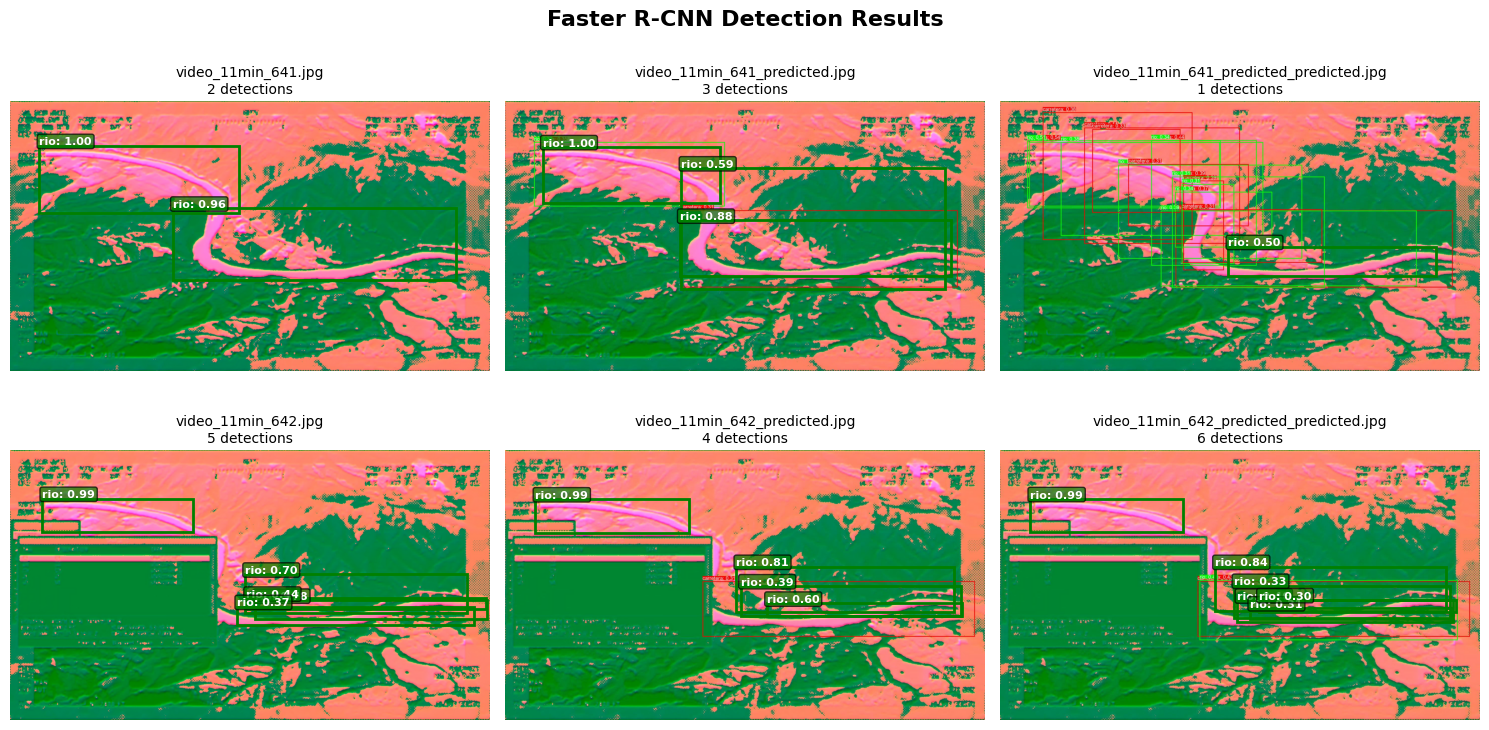


Available functions:
- evaluate_model_metrics(confidence_threshold=0.5)
- test_validation_images(confidence_threshold=0.3, show_plots=True)
- test_single_image('path/to/image.jpg', show_matplotlib=True)
- test_multiple_images('path/to/folder/', show_plots=True)
- show_image_grid(results)
- visualize_with_matplotlib(image, boxes, scores, labels, class_names)


In [8]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from sklearn.metrics import precision_recall_fscore_support, classification_report
from torchvision.ops import box_iou
from torch.utils.data import Dataset, DataLoader

# Check for matplotlib availability
try:
    import matplotlib.pyplot as plt
    print("matplotlib is available")
except ImportError:
    import subprocess
    import sys
    print("Installing matplotlib...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib"])
    import matplotlib.pyplot as plt
    print("matplotlib installed and imported")

class FasterRCNNDataset(Dataset):
    def __init__(self, images_dir, labels_dir):
        self.images_dir = Path(images_dir)
        self.labels_dir = Path(labels_dir)
        
        # Get image files
        self.image_files = []
        for ext in ['*.jpg', '*.jpeg', '*.png']:
            self.image_files.extend(list(self.images_dir.glob(ext)))
        
        # Fixed transform
        self.transform = T.Compose([T.ToTensor()])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Get labels
        label_name = img_path.stem + '.txt'
        label_path = self.labels_dir / label_name
        
        boxes = []
        labels = []
        
        if label_path.exists():
            with open(label_path, 'r') as f:
                for line in f:
                    if line.strip():
                        parts = line.strip().split()
                        if len(parts) >= 5:
                            # YOLO format: class_id x_center y_center width height (normalized)
                            # For Faster R-CNN, we need to add 1 to class_id (background class is 0)
                            class_id = int(parts[0]) + 1  # 1=carretera, 2=rio
                            x_center, y_center, width, height = map(float, parts[1:5])
                            
                            # Convert to absolute coordinates
                            img_width, img_height = image.size
                            x_center *= img_width
                            y_center *= img_height
                            width *= img_width
                            height *= img_height
                            
                            # Convert to [x1, y1, x2, y2]
                            x1 = max(0, x_center - width/2)
                            y1 = max(0, y_center - height/2)
                            x2 = min(img_width, x_center + width/2)
                            y2 = min(img_height, y_center + height/2)
                            
                            # Validate box
                            if x2 > x1 + 1 and y2 > y1 + 1:
                                boxes.append([x1, y1, x2, y2])
                                labels.append(class_id)
        
        # Handle empty annotations
        if len(boxes) == 0:
            boxes = [[0, 0, 10, 10]]  # Small dummy box
            labels = [1]  # Default to carretera (class 1)
        
        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {
            'boxes': boxes,
            'labels': labels,
        }
        
        # Apply transform
        image = self.transform(image)
        
        return image, target

def collate_fn(batch):
    """Collate function for Faster R-CNN dataloaders"""
    return tuple(zip(*batch))

def create_faster_rcnn_dataloaders():
    """Create Faster R-CNN dataloaders"""
    root = Path('data/ImagenesFiltradas')
    
    # Check paths
    val_images = root / 'val' / 'images'
    val_labels = root / 'val' / 'labels'
    
    # Create validation dataset
    val_dataset = FasterRCNNDataset(val_images, val_labels)
    
    # Create validation dataloader
    val_loader = DataLoader(
        val_dataset, 
        batch_size=8, 
        shuffle=False, 
        collate_fn=collate_fn, 
        num_workers=0,
        pin_memory=torch.cuda.is_available()
    )
    
    return val_loader

def load_trained_faster_rcnn(model_path='faster_rcnn_best.pth'):
    """Load the trained Faster R-CNN model"""
    print(f"Loading trained Faster R-CNN from: {model_path}")
    
    # Setup model architecture (same as training)
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Replace the classifier for 3 classes (background + carretera + rio)
    num_classes = 3  # background + carretera + rio
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # Load trained weights
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    print(f"Model loaded successfully on {device}")
    return model, device

def predict_image(model, image_path, device, confidence_threshold=0.3):
    """Make predictions on a single image"""
    
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    original_size = image.size
    
    # Transform for model input
    transform = T.Compose([T.ToTensor()])
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        predictions = model(input_tensor)
    
    # Extract predictions
    pred = predictions[0]
    boxes = pred['boxes'].cpu().numpy()
    scores = pred['scores'].cpu().numpy()
    labels = pred['labels'].cpu().numpy()
    
    # Filter by confidence threshold and remove background class (label 0)
    mask = (scores > confidence_threshold) & (labels > 0)
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]
    
    return image, boxes, scores, labels, original_size

def draw_predictions(image, boxes, scores, labels, class_names, save_path=None):
    """Draw bounding boxes and labels on image"""
    
    # Create a copy of the image to draw on
    draw_image = image.copy()
    draw = ImageDraw.Draw(draw_image)
    
    # Define colors for each class (note: class IDs are 1 and 2 for Faster R-CNN)
    colors = {
        1: (255, 0, 0),    # Red for carretera
        2: (0, 255, 0),    # Green for rio
    }
    
    # Try to load a font
    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except:
        font = ImageFont.load_default()
    
    print(f"Drawing {len(boxes)} detections:")
    
    for i, (box, score, label) in enumerate(zip(boxes, scores, labels)):
        x1, y1, x2, y2 = box
        color = colors.get(label, (255, 255, 0))  # Default yellow
        
        # Draw bounding box
        draw.rectangle([x1, y1, x2, y2], outline=color, width=3)
        
        # Prepare label text
        class_name = class_names.get(label, f"Class_{label}")
        label_text = f"{class_name}: {score:.2f}"
        
        # Draw label background
        text_bbox = draw.textbbox((x1, y1-25), label_text, font=font)
        draw.rectangle(text_bbox, fill=color)
        
        # Draw label text
        draw.text((x1, y1-25), label_text, fill=(255, 255, 255), font=font)
        
        print(f"  {i+1}. {class_name}: {score:.3f} at [{x1:.0f}, {y1:.0f}, {x2:.0f}, {y2:.0f}]")
    
    if save_path:
        draw_image.save(save_path)
        print(f"Result saved to: {save_path}")
    
    return draw_image

def visualize_with_matplotlib(image, boxes, scores, labels, class_names, title="Faster R-CNN Predictions"):
    """Visualize predictions using matplotlib"""
    
    plt.figure(figsize=(15, 10))
    plt.imshow(image)
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.axis('off')
    
    # Define colors for each class
    colors = {1: 'red', 2: 'green'}
    
    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box
        color = colors.get(label, 'yellow')
        
        # Draw rectangle
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                           fill=False, color=color, linewidth=3)
        plt.gca().add_patch(rect)
        
        # Add label
        class_name = class_names.get(label, f"Class_{label}")
        plt.text(x1, y1-10, f"{class_name}: {score:.2f}", 
                bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.8),
                fontsize=12, color='white', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def calculate_metrics_at_threshold(predictions, targets, confidence_threshold=0.5, iou_threshold=0.5):
    """Calculate precision, recall, F1-score at specific thresholds"""
    
    all_pred_labels = []
    all_gt_labels = []
    
    for pred, target in zip(predictions, targets):
        # Move all tensors to CPU for consistent processing
        pred_boxes = pred['boxes'].cpu()
        pred_labels = pred['labels'].cpu()
        pred_scores = pred['scores'].cpu()
        
        gt_boxes = target['boxes'].cpu()
        gt_labels = target['labels'].cpu()
        
        # Filter predictions by confidence
        conf_mask = pred_scores > confidence_threshold
        pred_boxes = pred_boxes[conf_mask]
        pred_labels = pred_labels[conf_mask]
        pred_scores = pred_scores[conf_mask]
        
        # For each ground truth, find if there's a matching prediction
        gt_matched = torch.zeros(len(gt_boxes), dtype=torch.bool)
        
        for gt_idx, (gt_box, gt_label) in enumerate(zip(gt_boxes, gt_labels)):
            best_iou = 0
            best_pred_idx = -1
            
            for pred_idx, (pred_box, pred_label) in enumerate(zip(pred_boxes, pred_labels)):
                if pred_label == gt_label:
                    # Ensure both boxes are on CPU
                    iou = box_iou(gt_box.unsqueeze(0), pred_box.unsqueeze(0)).item()
                    if iou > best_iou and iou >= iou_threshold:
                        best_iou = iou
                        best_pred_idx = pred_idx
            
            if best_pred_idx >= 0:
                gt_matched[gt_idx] = True
        
        # Add ground truth labels (convert from 1,2 to 0,1 for sklearn)
        for gt_label in gt_labels:
            if gt_label > 0:  # Skip background
                all_gt_labels.append(gt_label.item() - 1)  # Convert 1,2 to 0,1
        
        # Add predictions that matched ground truth
        for i, matched in enumerate(gt_matched):
            if matched:
                # Find which prediction matched this ground truth
                gt_label = gt_labels[i]
                all_pred_labels.append(gt_label.item() - 1)  # Convert 1,2 to 0,1
            else:
                # This ground truth was not detected (false negative)
                all_pred_labels.append(-1)  # Use -1 for missed detections
    
    # Remove -1 values and their corresponding ground truths for sklearn
    valid_indices = [i for i, pred in enumerate(all_pred_labels) if pred != -1]
    filtered_pred_labels = [all_pred_labels[i] for i in valid_indices]
    filtered_gt_labels = [all_gt_labels[i] for i in valid_indices]
    
    if len(filtered_pred_labels) == 0:
        return 0.0, 0.0, 0.0, {}
    
    # Calculate metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        filtered_gt_labels, filtered_pred_labels, average=None, zero_division=0
    )
    
    # Calculate overall metrics
    precision_macro = np.mean(precision) if len(precision) > 0 else 0.0
    recall_macro = np.mean(recall) if len(recall) > 0 else 0.0
    f1_macro = np.mean(f1) if len(f1) > 0 else 0.0
    
    class_names = {0: 'carretera', 1: 'rio'}
    detailed_metrics = {}
    
    for i, class_name in class_names.items():
        if i < len(precision):
            detailed_metrics[class_name] = {
                'precision': precision[i],
                'recall': recall[i],
                'f1': f1[i],
                'support': support[i] if i < len(support) else 0
            }
        else:
            detailed_metrics[class_name] = {
                'precision': 0.0,
                'recall': 0.0,
                'f1': 0.0,
                'support': 0
            }
    
    return precision_macro, recall_macro, f1_macro, detailed_metrics

def evaluate_model_metrics(model_path='faster_rcnn_best.pth', confidence_threshold=0.5):
    """Evaluate model with comprehensive metrics"""
    print("="*60)
    print("FASTER R-CNN COMPREHENSIVE EVALUATION")
    print("="*60)
    
    # Load model
    model, device = load_trained_faster_rcnn(model_path)
    
    # Load validation data
    val_loader = create_faster_rcnn_dataloaders()
    
    # Collect all predictions and targets
    all_predictions = []
    all_targets = []
    
    print(f"Evaluating on validation set with confidence threshold: {confidence_threshold}")
    
    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            predictions = model(images)
            
            all_predictions.extend(predictions)
            all_targets.extend(targets)
    
    # Calculate metrics
    precision, recall, f1, detailed_metrics = calculate_metrics_at_threshold(
        all_predictions, all_targets, confidence_threshold=confidence_threshold
    )
    
    print(f"\nOverall Metrics (confidence >= {confidence_threshold}):")
    print(f"  Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"  Recall: {recall:.4f} ({recall*100:.2f}%)")
    print(f"  F1-Score: {f1:.4f} ({f1*100:.2f}%)")
    
    print(f"\nPer-Class Metrics:")
    for class_name, metrics in detailed_metrics.items():
        print(f"  {class_name}:")
        print(f"    Precision: {metrics['precision']:.4f}")
        print(f"    Recall: {metrics['recall']:.4f}")
        print(f"    F1-Score: {metrics['f1']:.4f}")
        print(f"    Support: {metrics['support']}")
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'detailed_metrics': detailed_metrics
    }

def show_image_grid(results, max_images=6):
    """Show a grid of images with their predictions"""
    if not results:
        print("No results to display")
        return
    
    # Limit to max_images
    show_results = results[:max_images]
    
    # Calculate grid dimensions
    n_images = len(show_results)
    cols = min(3, n_images)
    rows = (n_images + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    fig.suptitle('Faster R-CNN Detection Results', fontsize=16, fontweight='bold')
    
    # Handle single image case
    if n_images == 1:
        axes = [axes]
    elif rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()
    
    class_names = {1: 'carretera', 2: 'rio'}
    colors = {1: 'red', 2: 'green'}
    
    for i, result in enumerate(show_results):
        # Load and display image
        image = Image.open(result['image_path'])
        axes[i].imshow(image)
        axes[i].set_title(f"{result['image_path'].name}\n{result['detections']} detections", 
                         fontsize=10)
        axes[i].axis('off')
        
        # Draw bounding boxes
        for box, score, label in zip(result['boxes'], result['scores'], result['labels']):
            x1, y1, x2, y2 = box
            color = colors.get(label, 'yellow')
            
            # Draw rectangle
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                               fill=False, color=color, linewidth=2)
            axes[i].add_patch(rect)
            
            # Add label
            class_name = class_names.get(label, f"Class_{label}")
            axes[i].text(x1, y1-5, f"{class_name}: {score:.2f}", 
                        bbox=dict(boxstyle="round,pad=0.2", facecolor=color, alpha=0.7),
                        fontsize=8, color='white', fontweight='bold')
    
    # Hide empty subplots
    for i in range(n_images, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def test_single_image(image_path, model_path='faster_rcnn_best.pth', confidence_threshold=0.3, 
                     save_result=True, show_matplotlib=True):
    """Test model on a single image"""
    
    print(f"Testing Faster R-CNN on: {image_path}")
    print("="*50)
    
    # Class mapping (note: Faster R-CNN uses 1=carretera, 2=rio)
    class_names = {1: 'carretera', 2: 'rio'}
    
    # Load model
    model, device = load_trained_faster_rcnn(model_path)
    
    # Make prediction
    image, boxes, scores, labels, original_size = predict_image(
        model, image_path, device, confidence_threshold
    )
    
    print(f"Image size: {original_size}")
    print(f"Confidence threshold: {confidence_threshold}")
    print(f"Found {len(boxes)} detections")
    
    if len(boxes) > 0:
        # Draw predictions
        result_image = draw_predictions(image, boxes, scores, labels, class_names)
        
        # Save result
        if save_result:
            input_path = Path(image_path)
            output_path = input_path.parent / f"{input_path.stem}_faster_rcnn_predicted{input_path.suffix}"
            result_image.save(output_path)
            print(f"Result saved to: {output_path}")
        
        # Show with matplotlib
        if show_matplotlib:
            visualize_with_matplotlib(image, boxes, scores, labels, class_names, 
                                    title=f"Faster R-CNN Results - {Path(image_path).name}")
        
        # Show detection summary
        print(f"\nDetection Summary:")
        for class_id, class_name in class_names.items():
            count = sum(1 for label in labels if label == class_id)
            if count > 0:
                avg_conf = np.mean([score for score, label in zip(scores, labels) if label == class_id])
                print(f"  {class_name}: {count} detections (avg confidence: {avg_conf:.3f})")
        
        return result_image, boxes, scores, labels
    else:
        print("No detections found!")
        print("Try lowering the confidence threshold (e.g., 0.1 or 0.2)")
        
        if show_matplotlib:
            plt.figure(figsize=(10, 6))
            plt.imshow(image)
            plt.title(f"No Detections - {Path(image_path).name}", fontsize=14)
            plt.axis('off')
            plt.show()
        
        return image, boxes, scores, labels

def test_multiple_images(images_dir, model_path='faster_rcnn_best.pth', 
                        confidence_threshold=0.3, max_images=5, show_plots=True):
    """Test model on multiple images from a directory"""
    
    print(f"Testing Faster R-CNN on images from: {images_dir}")
    print("="*60)
    
    images_path = Path(images_dir)
    
    # Find image files
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
    image_files = []
    for ext in image_extensions:
        image_files.extend(list(images_path.glob(ext)))
    
    if not image_files:
        print(f"No images found in {images_dir}")
        return
    
    print(f"Found {len(image_files)} images")
    
    # Load model once
    model, device = load_trained_faster_rcnn(model_path)
    class_names = {1: 'carretera', 2: 'rio'}
    
    # Test on multiple images
    test_files = image_files[:max_images]
    results = []
    
    for i, image_file in enumerate(test_files):
        print(f"\n--- Image {i+1}/{len(test_files)}: {image_file.name} ---")
        
        try:
            # Make prediction
            image, boxes, scores, labels, original_size = predict_image(
                model, image_file, device, confidence_threshold
            )
            
            print(f"Size: {original_size}, Detections: {len(boxes)}")
            
            if len(boxes) > 0:
                # Draw and save predictions
                result_image = draw_predictions(image, boxes, scores, labels, class_names)
                
                # Save result
                output_path = image_file.parent / f"{image_file.stem}_faster_rcnn_predicted{image_file.suffix}"
                result_image.save(output_path)
                
                results.append({
                    'image_path': image_file,
                    'output_path': output_path,
                    'detections': len(boxes),
                    'boxes': boxes,
                    'scores': scores,
                    'labels': labels
                })
            else:
                print("  No detections found")
                
        except Exception as e:
            print(f"  Error processing {image_file.name}: {e}")
    
    # Summary
    print(f"\n{'='*60}")
    print(f"SUMMARY - Processed {len(test_files)} images:")
    total_detections = sum(r['detections'] for r in results)
    print(f"  Total detections: {total_detections}")
    print(f"  Images with detections: {len(results)}")
    
    for class_id, class_name in class_names.items():
        class_count = sum(sum(1 for label in r['labels'] if label == class_id) for r in results)
        print(f"  {class_name}: {class_count} detections")
    
    # Show image grid if requested
    if show_plots and results:
        print(f"\nGenerating visualization plots...")
        show_image_grid(results, max_images=min(6, len(results)))
    
    return results

def test_validation_images(model_path='faster_rcnn_best.pth', confidence_threshold=0.3, show_plots=True):
    """Test on validation images"""
    val_images_dir = Path('data/ImagenesFiltradas/val/images')
    
    if val_images_dir.exists():
        print("Testing on validation images...")
        return test_multiple_images(val_images_dir, model_path, confidence_threshold, 
                                  max_images=10, show_plots=show_plots)
    else:
        print(f"Validation directory not found: {val_images_dir}")
        return None

def test_custom_image(image_path, confidence_threshold=0.3):
    """Test on a custom image"""
    if os.path.exists(image_path):
        return test_single_image(image_path, confidence_threshold=confidence_threshold)
    else:
        print(f"Image not found: {image_path}")
        return None

if __name__ == "__main__":
    print("FASTER R-CNN INFERENCE AND EVALUATION")
    print("="*50)
    
    # 1. Comprehensive metrics evaluation
    print("1. Calculating comprehensive metrics...")
    metrics_results = evaluate_model_metrics(confidence_threshold=0.5)
    
    # 2. Test on validation images with visualizations
    print("\n2. Testing on validation images with visualizations...")
    val_results = test_validation_images(confidence_threshold=0.3, show_plots=True)
    
    print("\nAvailable functions:")
    print("- evaluate_model_metrics(confidence_threshold=0.5)")
    print("- test_validation_images(confidence_threshold=0.3, show_plots=True)")
    print("- test_single_image('path/to/image.jpg', show_matplotlib=True)")
    print("- test_multiple_images('path/to/folder/', show_plots=True)")
    print("- show_image_grid(results)")
    print("- visualize_with_matplotlib(image, boxes, scores, labels, class_names)")